# SNS Sentiment Analysis BERT

Analyze social media texts and measure potential inflammatory / offensive language with a BERT neural network.

(This does not work, unable to pass data through the BERT model, Iter nor Tensor conversions are working at all for the data and model).

In [2]:
import ast
import data_util as du
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
from transformers import TFBertModel, BertTokenizer

In [ ]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=False, return_dict=False)
bert_model.trainable = False

In [3]:
print("Tensorflow Version : ", tf.__version__)
print("Transformers Version : ", transformers.__version__)

Tensorflow Version :  2.14.0
Transformers Version :  4.35.0


# Load the data

In [4]:
# Load dataset
train = pd.read_csv("./datasets/processed/train.csv")
X_train = train[train.columns[0]].apply(ast.literal_eval)
y_train = train[train.columns[1]].astype(int)
print(X_train.shape, y_train.shape)

test = pd.read_csv("./datasets/processed/test.csv")
X_test = test[test.columns[0]].apply(ast.literal_eval)
y_test = test[test.columns[1]].astype(int)
print(X_test.shape, y_test.shape)

(8000,) (8000,)
(2000,) (2000,)


In [5]:
train_text = [" ".join(s) for s in X_train]
test_text = [" ".join(s) for s in X_test]

In [6]:
# Testing
example_input = tokenizer(["Test sentence", "This is a test sentence"], padding='max_length', truncation=True, return_tensors='tf')
example_input

{'input_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[ 101, 3231, 6251, ...,    0,    0,    0],
       [ 101, 2023, 2003, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [7]:
MAX_LENGTH = 128

# Tokenize the training data
X_train_tokens = tokenizer.batch_encode_plus(
    train_text,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Tokenize the testing data
X_test_tokens = tokenizer.batch_encode_plus(
    test_text,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Create and train BERT neural network

In [8]:
def create_bert_model():
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='attention_mask')
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    sequence_output = bert_output[0]
    # Take the [CLS] token representation
    pooled_output = sequence_output[:, 0, :]

    x = tf.keras.layers.Dropout(0.2)(pooled_output)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [9]:
bert_classifier = create_bert_model()

In [10]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create a learning rate callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [11]:
BATCH_SIZE = 4

bert_history = bert_classifier.fit(
    [X_train_tokens['input_ids'], X_train_tokens['attention_mask'], X_train_tokens['token_type_ids']],
    y_train,
    epochs=5,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_text) // (BATCH_SIZE * 4),
    validation_data=([X_test_tokens['input_ids'], X_test_tokens['attention_mask'], X_test_tokens['token_type_ids']], y_test),
    validation_steps=BATCH_SIZE * 4,
    validation_batch_size=BATCH_SIZE,
    callbacks=lr_callback
)

Epoch 1/5
500/500 [==============================] - 43s 79ms/step - loss: 0.5723 - accuracy: 0.7265 - val_loss: 0.6305 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 2/5
500/500 [==============================] - 37s 75ms/step - loss: 0.5072 - accuracy: 0.7540 - val_loss: 0.9280 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 3/5
500/500 [==============================] - 37s 75ms/step - loss: 0.5259 - accuracy: 0.7415 - val_loss: 0.6956 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 4/5
500/500 [==============================] - 38s 76ms/step - loss: 0.5022 - accuracy: 0.7675 - val_loss: 0.7409 - val_accuracy: 0.6094 - lr: 9.0484e-04
Epoch 5/5
500/500 [==============================] - 43s 85ms/step - loss: 0.4887 - accuracy: 0.7680 - val_loss: 0.5935 - val_accuracy: 0.6719 - lr: 8.1873e-04


In [ ]:
# Saving model
bert_classifier.save('./models/sns_bert_model_2.keras')

In [ ]:
# Save weights, this is an important step
bert_classifier.save_weights('./models/sns_bert_2.weights.h5')

In [16]:
# Save model as JSON
bert_json = bert_classifier.to_json()
with open('./models/sns_bert_model_2.json', 'w') as f:
    f.write(bert_json)
    f.close()

In [ ]:
# Load model from weights
bert_loaded = create_bert_model()
bert_loaded.load_weights('./models/sns_bert_2.weights.h5')

In [21]:
# Our test data batch
test_data_batch = [X_test_tokens['input_ids'], X_test_tokens['attention_mask'], X_test_tokens['token_type_ids']]

In [22]:
# Assert loaded model and trained model are (almost) the same
np.testing.assert_allclose(
    bert_classifier.predict(test_data_batch),
    bert_loaded.predict(test_data_batch)
)

63/63 [==============================] - 41s 607ms/step


In [0]:
# Load model from architecture with weights
with open('./models/sns_bert_model_2.json', 'r') as f:
    json_config = f.read()
    f.close()
bert_json_loaded = tf.keras.models.model_from_json(json_config, custom_objects={'TFBertModel': TFBertModel})
bert_json_loaded.load_weights('./models/sns_bert_2.weights.h5')

In [23]:
# Test trained model
bert_preds = bert_classifier.predict(test_data_batch)

63/63 [==============================] - 50s 793ms/step


In [26]:
# Test loaded model
loaded_bert_preds = bert_loaded.predict(test_data_batch)

7/7 [==============================] - 8s 763ms/step


In [71]:
# Test loaded JSON model
bert_json_preds = bert_json_loaded.predict(test_data_batch)

7/7 [==============================] - 12s 1s/step


In [24]:
_ = du.get_prfa(y_test, du.probs_to_preds(bert_preds), verbose=True)

Precision: 0.8168202764976958
Recall: 0.7139979859013091
F1 Score: 0.7619559376679204
Accuracy: 0.7785


In [27]:
_ = du.get_prfa(y_test, du.probs_to_preds(loaded_bert_preds), verbose=True)

Precision: 0.8028169014084507
Recall: 0.5
F1 Score: 0.6162162162162163
Accuracy: 0.645


In [72]:
_ = du.get_prfa(y_test, du.probs_to_preds(bert_json_preds), verbose=True)

Precision: 0.8028169014084507
Recall: 0.5
F1 Score: 0.6162162162162163
Accuracy: 0.645


In [104]:
metrics = bert_classifier.evaluate(test_data_batch, y_test)
print("Loss:", metrics[0])
print("Accuracy:", metrics[1]) 

7/7 [==============================] - 15s 2s/step - loss: 1.1698 - accuracy: 0.5950
Loss: 1.1697783470153809
Accuracy: 0.5950000286102295


In [108]:
# Use a smaller batch of test data
demo_data = tokenizer(test_text[:5], return_tensors="tf", max_length=128, padding='max_length', truncation=True)

demo_predictions = bert_classifier.predict([demo_data['input_ids'], demo_data['attention_mask'], demo_data['token_type_ids']])

_ = du.get_prfa(y_test[:5], du.probs_to_preds(demo_predictions), verbose=True)

1/1 [==============================] - 5s 5s/step
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
Accuracy: 0.8


<Figure size 500x800 with 0 Axes>

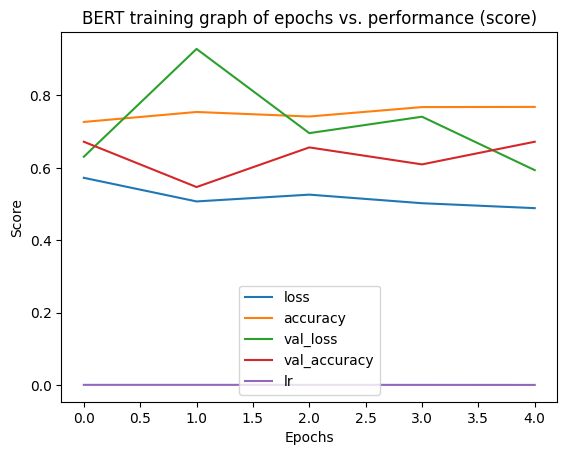

In [25]:
plt.figure(figsize=(5, 8))
pd.DataFrame(bert_history.history).plot()
plt.savefig('./graphs/bert_history_4.png')
plt.title("BERT training graph of epochs vs. performance (score)")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.show()